<a href="https://colab.research.google.com/github/jtfreitas/QInfo_Final/blob/main/FRUIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install tensornetwork jax jaxlib -q gwpy #--quiet flag
# !pip uninstall -q matplotlib
# !pip install -q matplotlib  #fixing a problem with matplotlib

In [1]:
import tensornetwork as tn
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense,MaxPooling2D,Conv2D,Dropout,Flatten, AveragePooling2D
from tensornetwork.tn_keras.layers import Conv2DMPO, DenseMPO, DenseDecomp
from tensorflow.keras import regularizers, initializers, optimizers, Input
from tensorflow.keras.callbacks import ModelCheckpoint
import time
import pandas as pd
import matplotlib.pyplot as plt
tn.set_default_backend('tensorflow')
import tensorflow_datasets as tfds
import os
import json

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

2022-03-03 10:05:25.070294: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-03 10:05:25.080354: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-03 10:05:25.080984: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


# Classical convolutional NN model
data has 131 labels

image parameters

In [2]:
train_dir = os.getcwd() + "/datasets/fruits360/Training"
test_dir  = os.getcwd() + "/datasets/fruits360/Test"
batch_size = 4*131
img_height = 100
img_width = 100

In [3]:
#Ideally, we want the batch to be large enough to contain at least one sample
#of each class
#Otherwise the model makes conclusions before seeing all types of data

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  labels = 'inferred',
  label_mode='categorical',
  color_mode = 'rgb',
  validation_split= 0.2,
  subset = 'training',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  labels = 'inferred',
  label_mode='categorical',
  color_mode = 'rgb',
    validation_split= 0.2,
  subset = 'validation',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

print('\nTest data:')
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  labels = 'inferred',
  label_mode='categorical',
  color_mode = 'rgb',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 67692 files belonging to 131 classes.
Using 54154 files for training.


2022-03-03 10:05:27.429117: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-03 10:05:27.429519: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-03 10:05:27.430207: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-03 10:05:27.430771: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

Found 67692 files belonging to 131 classes.
Using 13538 files for validation.

Test data:
Found 22688 files belonging to 131 classes.


2022-03-03 10:05:33.205780: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


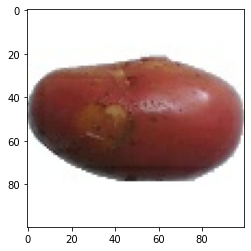

Label : 108


In [4]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_ds_train = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch_train, labels_batch_train = next(iter(normalized_ds_train))

normalized_ds_val = val_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch_val, labels_batch_val = next(iter(normalized_ds_val))

first_image = image_batch_train[0]
in_shape = first_image.shape

plt.imshow(first_image)
plt.show()
print(f"Label : {np.argmax(labels_batch_train[0])}")

In [5]:
# classical_model = tf.keras.Sequential([
#   tf.keras.Input(shape=in_shape),
#   tf.keras.layers.Conv2D(16,kernel_size = 3, activation='LeakyReLU'),
#   tf.keras.layers.MaxPooling2D(),

#   tf.keras.layers.Conv2D(16,kernel_size = 3, activation='LeakyReLU'),
#   tf.keras.layers.MaxPooling2D(),
#   tf.keras.layers.Flatten(),
#   tf.keras.layers.Dense(131, activation='softmax'),
# ])

dense_reg = regularizers.l2(1e-4)
conv_reg  = regularizers.l2(1e-5)
#Defined a model using some layer regularizers to avoid overfitting

classical_model = tf.keras.Sequential([
    tf.keras.Input(shape=in_shape),
    tf.keras.layers.Conv2D(16, kernel_size = 2, activation='relu', kernel_regularizer=conv_reg, activity_regularizer=conv_reg, name='conv1'),
    tf.keras.layers.MaxPooling2D((2,2), name = 'max_pool1'),
    tf.keras.layers.Conv2D(32, kernel_size = 2, activation='relu', kernel_regularizer=conv_reg, activity_regularizer=conv_reg, name='conv2'),
    tf.keras.layers.MaxPooling2D((2,2), name = 'max_pool2'),
    tf.keras.layers.Conv2D(128, kernel_size = 2, activation='relu', kernel_regularizer=conv_reg, activity_regularizer=conv_reg, name='conv3'),
    tf.keras.layers.MaxPooling2D((2,2), name = 'max_pool3'),
    tf.keras.layers.Flatten(name='flatten1'),
    tf.keras.layers.Dropout(0.5, name='dropout1'),
    tf.keras.layers.Dense(180, activation = 'relu', kernel_regularizer=dense_reg, activity_regularizer=dense_reg, name='dense1'),
    tf.keras.layers.Dropout(0.2, name='dropout2'),
    tf.keras.layers.Dense(131, activation='softmax', kernel_regularizer=dense_reg, activity_regularizer=dense_reg, name='out_dense')
])


classical_model.summary()


lr_schedule = optimizers.schedules.ExponentialDecay(0.01, 1600, 0.1)
#The loss was blowing up, meaning the training was reaching a point where
#the learning rate was too large, so I wrote it with a schedule which makes it
#decay to 10% every 500 training steps (batch runs)
#https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay

opt = optimizers.Adam(learning_rate = lr_schedule, amsgrad=True)
classical_model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 99, 99, 16)        208       
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 49, 49, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 48, 48, 32)        2080      
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 24, 24, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 23, 23, 128)       16512     
_________________________________________________________________
max_pool3 (MaxPooling2D)     (None, 11, 11, 128)       0         
_________________________________________________________________
flatten1 (Flatten)           (None, 15488)             0

In [6]:
check_point = ModelCheckpoint(filepath = os.getcwd()+'/classic_CNN.hdf5', verbose = 0, save_best_only = True)

with tf.device('GPU'): #just to make sure the training occurs in the GPU, even though it's default
    hist_dict_cl = classical_model.fit(train_ds, validation_data=val_ds, epochs = 15, verbose = 1, shuffle=True, callbacks = [check_point])

with open(os.getcwd()+"/classic_history.json", 'w') as f:
    json.dump(hist_dict_cl.history, f)

Epoch 1/15


2022-03-03 10:05:45.737203: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


104/104 [==============================] - 22s 172ms/step - loss: 190.5636 - accuracy: 0.2786 - val_loss: 2.4566 - val_accuracy: 0.6410
Epoch 2/15
104/104 [==============================] - 18s 166ms/step - loss: 2.3694 - accuracy: 0.6294 - val_loss: 1.7154 - val_accuracy: 0.8164
Epoch 3/15
104/104 [==============================] - 18s 166ms/step - loss: 1.8165 - accuracy: 0.7688 - val_loss: 1.3340 - val_accuracy: 0.9155
Epoch 4/15
104/104 [==============================] - 18s 167ms/step - loss: 1.5467 - accuracy: 0.8345 - val_loss: 1.1432 - val_accuracy: 0.9610
Epoch 5/15
104/104 [==============================] - 18s 166ms/step - loss: 1.2663 - accuracy: 0.9025 - val_loss: 1.0171 - val_accuracy: 0.9781
Epoch 6/15
104/104 [==============================] - 18s 166ms/step - loss: 1.1738 - accuracy: 0.9174 - val_loss: 0.9365 - val_accuracy: 0.9874
Epoch 7/15
104/104 [==============================] - 17s 162ms/step - loss: 0.9982 - accuracy: 0.9545 - val_loss: 0.8382 - val_accuracy: 0

In [14]:
classical_model.load_weights("classic_CNN.hdf5")

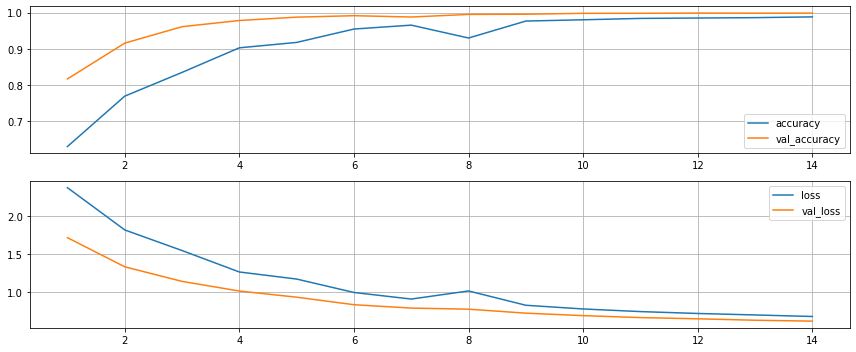

In [7]:
def plot_loss_acc(fit_history, starting_epoch=1, **kwargs):
    fig, axs = plt.subplots(2,1, **kwargs)

    for key in fit_history.keys():
        if 'acc' in key:
            axs[0].plot(range(1, len(fit_history[key][starting_epoch-1:])+1), fit_history[key][starting_epoch-1:], label=key)
        elif 'loss' in key:
            axs[1].plot(range(1, len(fit_history[key][starting_epoch-1:])+1), fit_history[key][starting_epoch-1:], label=key)

    for ax in axs:
        ax.legend()
        ax.grid()
    return fig

with open(os.getcwd()+'/classic_history.json', 'r') as json_hist:
    hist_dict = json.load(json_hist)

acc_loss_classic = plot_loss_acc(hist_dict, starting_epoch = 2, figsize=(12,5), tight_layout='pad')

In [8]:
classical_model.evaluate(test_ds)

44/44 [==============================] - 4s 81ms/step - loss: 0.8746 - accuracy: 0.9291


[0.8746353983879089, 0.9291255474090576]

In [11]:
#Building the tensor network

class TNLayer(tf.keras.layers.Layer):

  def __init__(self, bond_dim, **kwargs):
    super(TNLayer, self).__init__(**kwargs)
        # Create the variables for the layer.
    self.a_var = tf.Variable(tf.random.normal(shape=(4, 24, bond_dim),stddev=1.0/16.0),
                  name="a",
                  trainable=True)
    self.b_var = tf.Variable(tf.random.normal(shape=(4, 256, bond_dim, bond_dim), stddev=1.0/16.0),
                  name="b",
                  trainable=True)
    self.c_var = tf.Variable(tf.random.normal(shape=(4, 24, bond_dim), stddev=1.0/16.0),
                  name="c",
                  trainable=True)
    self.bias = tf.Variable(tf.zeros(shape=(4,4,4)),
                  name="bias",
                  trainable=True)

  def call(self, inputs):
    def f(input_vec, a_var, b_var, c_var, bias_var):
      result = tn.ncon([input_vec, a_var, b_var, c_var], [[1, 2, 3], [-1, 1, 4], [-2, 3, 4, 5], [-3, 2, 5]]) 
      return result + bias_var

        # To deal with a batch of items, we can use the tf.vectorized_map
        # function.
        # https://www.tensorflow.org/api_docs/python/tf/vectorized_map
    result = tf.vectorized_map(
      lambda vec: f(vec, self.a_var, self.b_var, self.c_var, self.bias), inputs
    )
    return tf.nn.relu(tf.reshape(result, (-1,64)))

In [12]:
tn_reg_dense = regularizers.l2(1e-5)
tn_reg_conv  = regularizers.l2(1e-5)

tn_convolutional_model = tf.keras.Sequential([
    Input((in_shape)),
    Conv2D(4, kernel_size=4),
    Conv2DMPO(16, data_format = "channels_last", kernel_size=2, num_nodes=2, bond_dim=8, activation="relu", activity_regularizer = tn_reg_conv),
    MaxPooling2D(pool_size=(2,2)),
    Conv2DMPO(256, data_format = "channels_last", kernel_size=2, num_nodes=4, bond_dim=8, activation="relu", activity_regularizer = tn_reg_conv),
    MaxPooling2D(pool_size=(2,2)),
    # Conv2DMPO(256, data_format = "channels_last", kernel_size=2, num_nodes=4, bond_dim=8, activation="relu"),
    TNLayer(bond_dim = 5, activity_regularizer = tn_reg_dense),
    Dense(131, activation='softmax')])

tn_convolutional_model.summary()

lr_schedule = optimizers.schedules.ExponentialDecay(0.01, 800, 0.1)
#The loss was blowing up, meaning the training was reaching a point where
#the learning rate was too large, so I wrote it with a schedule which makes it
#decay to 10% every 500 training steps (batch runs)
#https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay

opt = optimizers.Adam(learning_rate = lr_schedule, amsgrad=True)
tn_convolutional_model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'], run_eagerly=False)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 97, 97, 4)         196       
_________________________________________________________________
conv2dmpo_2 (Conv2DMPO)      (None, 97, 97, 16)        272       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 48, 48, 16)        0         
_________________________________________________________________
conv2dmpo_3 (Conv2DMPO)      (None, 48, 48, 256)       1536      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 24, 24, 256)       0         
_________________________________________________________________
tn_layer_1 (TNLayer)         (None, 64)                26624     
_________________________________________________________________
dense_1 (Dense)              (None, 131)              

In [13]:
with tf.device('GPU'):
    hist_dict_convolutional_tn = tn_convolutional_model.fit(train_ds, validation_data=val_ds, epochs = 10, verbose = 1, shuffle=True)


with open(os.getcwd()+"/tn_history.json", 'w') as f:
    json.dump(hist_dict_cl.history, f)

Epoch 1/10


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_2/tn_layer_1/loop_body/GatherV2/pfor/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_2/tn_layer_1/loop_body/GatherV2/pfor/Reshape:0", shape=(None, 24, 24, 256), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_2/tn_layer_1/loop_body/GatherV2/pfor/Cast:0", shape=(4,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


104/104 [==============================] - 53s 470ms/step - loss: 42.4552 - accuracy: 0.2457 - val_loss: 1.7731 - val_accuracy: 0.5527
Epoch 2/10
104/104 [==============================] - 47s 452ms/step - loss: 1.2376 - accuracy: 0.6821 - val_loss: 0.9558 - val_accuracy: 0.7624
Epoch 3/10
104/104 [==============================] - 48s 454ms/step - loss: 0.8017 - accuracy: 0.7990 - val_loss: 0.6368 - val_accuracy: 0.8548
Epoch 4/10
104/104 [==============================] - 48s 455ms/step - loss: 0.6934 - accuracy: 0.8319 - val_loss: 0.6695 - val_accuracy: 0.8468
Epoch 5/10
104/104 [==============================] - 48s 455ms/step - loss: 0.5040 - accuracy: 0.8857 - val_loss: 0.4032 - val_accuracy: 0.9185
Epoch 6/10
104/104 [==============================] - 48s 455ms/step - loss: 0.5491 - accuracy: 0.9011 - val_loss: 7.8818 - val_accuracy: 0.0303
Epoch 7/10
104/104 [==============================] - 48s 457ms/step - loss: 4.1232 - accuracy: 0.1230 - val_loss: 3.0531 - val_accuracy: 0.

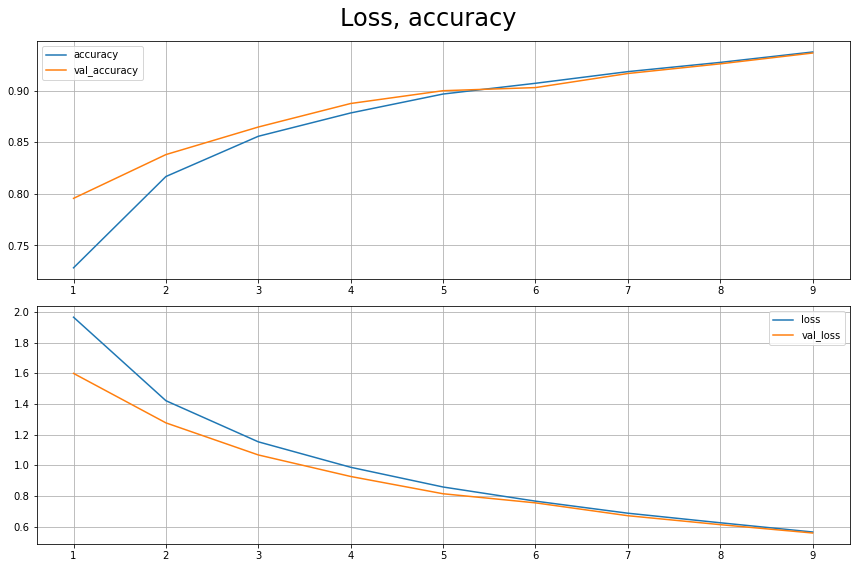

In [61]:
plot_fig = plot_loss_acc(hist_dict_convolutional_tn.history, starting_epoch = 2, figsize=(12,8), tight_layout='pad')
plot_fig.suptitle('Loss, accuracy', fontsize=24)

plot_fig.show()

In [76]:
test_tensor = tf.zeros((524, 16, 16, 16))

In [81]:
ay = tf.reshape(test_tensor, (-1, 4096))

tf.reshape(ay, (-1, 4096*524))

<tf.Tensor: shape=(1, 2146304), dtype=float32, numpy=array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [25]:
tn_convolutional_model.history

TypeError: 'History' object is not subscriptable

# Toy model

In [40]:
from scipy.special import binom

def feat_map(x_j, d):
    phi = np.array([np.sqrt(binom(d-1, i - 1))*np.cos(np.pi/2*x_j)**(d-i)*np.sin(np.pi/2*x_j)**(i-1) for i in range(1,d+1)])
    return phi

In [69]:
from scipy.stats import multivariate_normal as mv_norm

unit_sq = np.array([[0,1], [0,1]])
xi, yi = np.meshgrid(*unit_sq)
pos = np.dstack([xi, yi])
f_val = mv_norm.pdf(pos, mean=[0,0], cov=np.array([[1,1],[1,1]]), allow_singular=True)

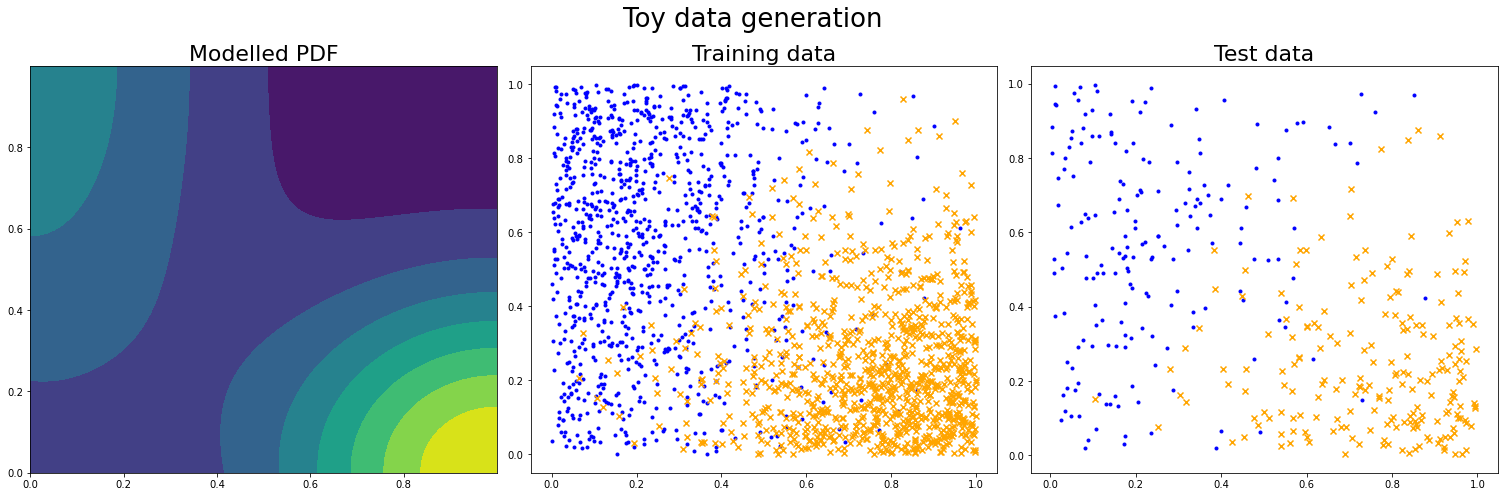

In [305]:
from sklearn.model_selection import train_test_split
unit_sq = np.mgrid[0:1:.001, 0:1:.001]
pos = np.dstack(unit_sq)
rv_tL = mv_norm([0., 1.], [[0.1, 0], [0, 0.5]]) #top-Left gaussian
rv_bR = mv_norm([1., 0.], [[0.1, 0], [0, 0.1]]) #bottom-Right gaussian

mask_arr = rv_tL.pdf(pos) == rv_bR.pdf(pos)

decision_bound = pos[mask_arr]

no_samples = 10000
x1, y1 = rv_tL.rvs(no_points, random_state=123), np.zeros(no_points)
x1 = x1[np.array([all([x_1 > 0, x_1 < 1, x_2 > 0, x_2 < 1]) for x_1, x_2 in x1])]
x2, y2 = rv_bR.rvs(no_points, random_state=123),  np.ones(no_points)
x2 = x2[np.array([all([x_1 > 0, x_1 < 1, x_2 > 0, x_2 < 1]) for x_1, x_2 in x2])]

max_pts = 1000
x1, y1 = x1[:max_pts], y1[:max_pts]
x2, y2 = x2[:max_pts], y2[:max_pts]

x, y = np.vstack([x1,x2]), np.vstack([y1,y2]).flatten()

shuffler = np.random.permutation(len(x))

x, y = x[shuffler], y[shuffler]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=420)


fig = plt.figure(figsize=(21,7), tight_layout='pad')
ax1 = fig.add_subplot(131)
ax1.contourf(*unit_sq, rv_tL.pdf(pos)+rv_bR.pdf(pos))
ax1.scatter(*decision_bound.T)
ax1.set_title('Modelled PDF', fontsize=22)

ax2 = fig.add_subplot(132)
ax2.scatter(*x1.T[:50], marker='.', color='blue')
ax2.scatter(*x2.T[:50], marker='x', color='orange')
ax2.set_title('Training data', fontsize=22)

ax3 = fig.add_subplot(133)
ax3.scatter(*x_test[y_test == 0].T, marker = '.', color = 'blue')
ax3.scatter(*x_test[y_test == 1].T, marker = 'x', color = 'orange')
ax3.set_title('Test data', fontsize=22)
fig.suptitle('Toy data generation', fontsize=26)
fig.show()

In [307]:
mask_arr

False

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()